<a href="https://colab.research.google.com/github/neillinehan/NeilLinehanPortfolio/blob/main/omaha_food_county_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Set up

In [ ]:
!apt install libspatialindex-dev
!sudo pip3 install rtree
!pip install geopandas
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import itertools
%matplotlib inline

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 0s (1,216 kB/s)
Selecting previously unselected package libspatialind

###### Define projection for spatial data

In [ ]:


#projection WKT

proj_wkt = """PROJCS["ProjWiz_Custom_Albers",
 GEOGCS["GCS_WGS_1984",
  DATUM["D_WGS_1984",
   SPHEROID["WGS_1984",6378137.0,298.257223563]],
  PRIMEM["Greenwich",0.0],
  UNIT["Degree",0.0174532925199433]],
 PROJECTION["Albers"],
 PARAMETER["False_Easting",0.0],
 PARAMETER["False_Northing",0.0],
 PARAMETER["Central_Meridian",-96.1523438],
 PARAMETER["Standard_Parallel_1",28.5553737],
 PARAMETER["Standard_Parallel_2",45.3084144],
 PARAMETER["Latitude_Of_Origin",36.931894],
 UNIT["Meter",1.0]]"""

##### Load and preprocess spatial data

###### Load Omaha county flow data

In [ ]:
ao_gdf = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Personal Projects/food flows/county_omaha_flows',)

###### Load metropolitan area data and drop unnecessary columns

In [ ]:
metro_areas = gpd.read_file("https://faf.ornl.gov/faf5/data/2017_CFS_Metro_Areas_with_FAF.zip")
metro_areas = metro_areas.drop(columns=['CFS07_NAME','CFS12_NAME','CFS17_NA_1','FAF_Zone_D','FAF_Zone_1','ALAND','AWATER'])

##### Load and preprocess supplementary data


###### Load data dictionary and rename columns

In [ ]:
data_dict = pd.read_excel('https://www2.census.gov/programs-surveys/cfs/datasets/2017/cfs-2017-puf-users-guide-app-a-aug2020.xlsx', sheet_name=1, skiprows=[0,1])
data_dict = data_dict.rename(columns={'Unnamed: 4': 'CFS17_NAME'}) #rename column for merge
data_dict.CFS17_NAME = data_dict.CFS17_NAME.str.strip() #remove blank character for merge
data_dict.iloc[84:132,4] = data_dict.iloc[84:132,4].str.rsplit(n=2, expand=True)[0] #cleanup data

#####Merge spatial and supplementary data

###### Merge metropolitan area data with data dictionary

In [ ]:
shape_sdf = pd.merge(metro_areas,data_dict,how="left", on='CFS17_NAME') #merge, linking destMA and state with shapes
# Rename columns for consistency
shape_sdf = shape_sdf.rename(columns={'DEST_MA': 'ORIG_MA','DEST_STATE': 'ORIG_STATE', 'DEST_CFS_AREA':'ORIG_CFS_A'})
shape_sdf['ORIG_CFS_A'] = shape_sdf['ORIG_CFS_A'].astype(str)
shape_sdf = shape_sdf.to_crs(proj_wkt) #reproject to appropiate Albers equal-area conic

##### Load shapefile for American states

In [ ]:
contig = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip", crs=proj_wkt)
contig = contig.drop([13,27,37,38,44,45,42]) #remove territories outside the continental United States with no imports to Omaha
contig = contig.to_crs(proj_wkt) #reproject to appropiate Albers equal-area conic

##### Load road network data

In [ ]:
route_gdf = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Personal Projects/food flows/route',crs=proj_wkt)
route_gdf = route_gdf.to_crs(proj_wkt) #reproject to appropiate Albers equal-area conic

# Estimate Shipment Values

#### WGT_FACTOR represents estimated amount of shipments. This process estimates the total value, weight and distance of shipments to Omaha from the various regions. As given by CFS documentation.

In [ ]:
ao_gdf['est_val'] = ao_gdf['SHIPMT_VAL'] * ao_gdf['WGT_FACTOR']
ao_gdf['est_lbs'] = ao_gdf['SHIPMT_WGH'] * ao_gdf['WGT_FACTOR']
ao_gdf['est_dst'] = ao_gdf['SHIPMT_D_1'] * ao_gdf['WGT_FACTOR']

Set missing geometries

In [ ]:
ao_gdf.loc[[422],'geometry']  = contig.loc[contig['STATEFP'] == '51','geometry'].values
ao_gdf.loc[[1154],'geometry']  = contig.loc[contig['STATEFP'] == '51','geometry'].values
ao_gdf.loc[[1444],'geometry']  = contig.loc[contig['STATEFP'] == '51','geometry'].values
ao_gdf.loc[[2552],'geometry']  = contig.loc[contig['STATEFP'] == '51','geometry'].values
ao_gdf.loc[[2848],'geometry']  = contig.loc[contig['STATEFP'] == '51','geometry'].values
ao_gdf.loc[[3039],'geometry']  = contig.loc[contig['STATEFP'] == '51','geometry'].values
ao_gdf.loc[[3102],'geometry']  = contig.loc[contig['STATEFP'] == '51','geometry'].values
ao_gdf.loc[[3150],'geometry']  = contig.loc[contig['STATEFP'] == '51','geometry'].values
ao_gdf.loc[[2452],'geometry']  = contig.loc[contig['STATEFP'] == '20','geometry'].values
ao_gdf.loc[[2596],'geometry']  = contig.loc[contig['STATEFP'] == '20','geometry'].values
ao_gdf.loc[ao_gdf['ORIG_CFS_A'] == '17-00000','geometry'] = [contig.loc[contig['STATEFP'] == '17','geometry']]
ao_gdf.loc[ao_gdf['ORIG_CFS_A'] == '06-00000','geometry'] = [contig.loc[contig['STATEFP'] == '06','geometry']]

#Calculate Statistics for Each Region

In [ ]:
#Group each CFS area and calculate summary statistics
sum_gdf = ao_gdf.groupby(by='ORIG_CFS_A',as_index=False).sum()[['ORIG_CFS_A','SHIPMT_VAL','SHIPMT_WGH','SHIPMT_DIS','SHIPMT_D_1','WGT_FACTOR','est_val','est_lbs','est_dst']]
#add back geometries
sum_gdf = pd.merge(ao_gdf[['ORIG_CFS_A','geometry']],sum_gdf, how='right',on='ORIG_CFS_A')

In [ ]:
#group each CFS area
sum_gdf = ao_gdf.groupby(by='ORIG_CFS_A',as_index=False).sum()[['ORIG_CFS_A','SHIPMT_VAL','SHIPMT_WGH','SHIPMT_DIS','SHIPMT_D_1','WGT_FACTOR','est_val','est_lbs','est_dst']]
#add back geometries
sum_gdf = pd.merge(ao_gdf[['ORIG_CFS_A','geometry']],sum_gdf, how='right',on='ORIG_CFS_A')
sum_gdf['ORIG_CFS_A'] = sum_gdf['ORIG_CFS_A'].astype(str)
#cleanup duplicates
sum_gdf = sum_gdf.drop_duplicates()
#add CFS areas with no imports into Omaha region for mapping purposes
sum_gdf = pd.merge(shape_sdf[['ORIG_CFS_A','geometry']],sum_gdf,how='outer',on='geometry').fillna(0)
#drop Hawaii and Alaska
sum_gdf = sum_gdf.drop([126,74,65])

redistributing "downgraded" state level geomtries into valid within-state CFS areas by occupied propotion

In [ ]:
sum_gdf.loc[  sum_gdf['ORIG_CFS_A_y'].str.contains("06-"r'[1-9]',na=False)  , ['est_val','est_lbs','est_dst']  ] =  sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains("06-"r'[1-9]',na=False)][['est_val','est_lbs','est_dst']] + sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains("06-"r'[1-9]',na=False)][['est_val','est_lbs','est_dst']]/sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains("06-"r'[1-9]',na=False)][['est_val','est_lbs','est_dst']].sum() * sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains('06-0',na=False)][['est_val','est_lbs','est_dst']].transpose().iloc[:,0]
sum_gdf.loc[  sum_gdf['ORIG_CFS_A_y'].str.contains("17-"r'[1-9]',na=False)  , ['est_val','est_lbs','est_dst']  ] = sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains("17-"r'[1-9]',na=False)][['est_val','est_lbs','est_dst']] + sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains("17-"r'[1-9]',na=False)][['est_val','est_lbs','est_dst']]/sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains("17-"r'[1-9]',na=False)][['est_val','est_lbs','est_dst']].sum() * sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains('17-0',na=False)][['est_val','est_lbs','est_dst']].transpose().iloc[:,0]
sum_gdf.loc[  sum_gdf['ORIG_CFS_A_y'].str.contains("20-"r'[1-9]',na=False)  , ['est_val','est_lbs','est_dst']  ] = sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains("20-"r'[1-9]',na=False)][['est_val','est_lbs','est_dst']] + sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains("20-"r'[1-9]',na=False)][['est_val','est_lbs','est_dst']]/sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains("20-"r'[1-9]',na=False)][['est_val','est_lbs','est_dst']].sum() * sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains('20-0',na=False)][['est_val','est_lbs','est_dst']].transpose().iloc[:,0]
sum_gdf.loc[  sum_gdf['ORIG_CFS_A_y'].str.contains("51-"r'[1-9]',na=False)  , ['est_val','est_lbs','est_dst']  ] = sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains("51-"r'[1-9]',na=False)][['est_val','est_lbs','est_dst']] + sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains("51-"r'[1-9]',na=False)][['est_val','est_lbs','est_dst']]/sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains("51-"r'[1-9]',na=False)][['est_val','est_lbs','est_dst']].sum() * sum_gdf[sum_gdf['ORIG_CFS_A_y'].str.contains('51-0',na=False)][['est_val','est_lbs','est_dst']].transpose().iloc[:,0]

In [ ]:
sum_gdf['CV_val'] = np.exp(3.955 + -0.033*np.log(sum_gdf['WGT_FACTOR'])+ -0.016*(np.log(sum_gdf['WGT_FACTOR'])**2)) # as given in CFS documentation
sum_gdf['CV_lbs'] = np.exp(3.815 + -0.045*np.log(sum_gdf['WGT_FACTOR'])+ -0.017*(np.log(sum_gdf['WGT_FACTOR'])**2))
sum_gdf['CV_dst'] = np.exp(3.958 + -0.020*np.log(sum_gdf['WGT_FACTOR'])+ -0.015*(np.log(sum_gdf['WGT_FACTOR'])**2))

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
total_stat = sum_gdf.iloc[:,[7,8,9,10]].sum()

#### stats for total shipments into Omaha region

In [ ]:
# Calculate total statistics
total_stat = sum_gdf.iloc[:,[7,8,9,10]].sum()
# Calculate total value coefficient of variation (CV) as per CFS documentation
total_stat['CV_tot_val'] = np.exp(3.955 + -0.033*np.log(total_stat['WGT_FACTOR'])+ -0.016*(np.log(total_stat['WGT_FACTOR'])**2))
# Calculate total weight (lbs) coefficient of variation (CV)
total_stat['CV_tot_lbs'] = np.exp(3.815 + -0.045*np.log(total_stat['WGT_FACTOR'])+ -0.017*(np.log(total_stat['WGT_FACTOR'])**2))
# Calculate total distance coefficient of variation (CV)
total_stat['CV_tot_dst'] = np.exp(3.958 + -0.020*np.log(total_stat['WGT_FACTOR'])+ -0.015*(np.log(total_stat['WGT_FACTOR'])**2))

#### Aggregate trade data by SCTG and origin CFS area, then merge with shapefiles for visualization.

In [ ]:
# Aggregate trade data by SCTG and origin CFS area
sctg_gdf = ao_gdf.groupby(by=['ORIG_CFS_A','SCTG'],as_index=False).sum()[['ORIG_CFS_A','SCTG','SHIPMT_VAL','SHIPMT_WGH','SHIPMT_DIS','SHIPMT_D_1','WGT_FACTOR','est_val','est_lbs','est_dst']]
# Merge with origin CFS area geometries
sctg_gdf = pd.merge(ao_gdf[['ORIG_CFS_A','geometry']],sctg_gdf, how='right',on='ORIG_CFS_A')
# Convert ORIG_CFS_A to string
sctg_gdf['ORIG_CFS_A'] = sctg_gdf['ORIG_CFS_A'].astype(str)
# Remove duplicates
sctg_gdf = sctg_gdf.drop_duplicates()
# Merge with shapefile geometries, filling missing values with 1
sctg_gdf = pd.merge(shape_sdf[['ORIG_CFS_A','geometry']],sctg_gdf,how='outer',on='geometry').fillna(1)
# Drop specific rows
sctg_gdf = sctg_gdf.drop([104,236,237,121])

#route density

Extract the starting coordinates of each route and convert them to geometry points.

In [ ]:
# Extract start coordinates of each linestring
first_coord = route_gdf["geometry"].apply(lambda g: g.coords[0])
# Add start as columns to the gdf
route_gdf["start_coord"] = first_coord
#convert coordinate to geometry
route_gdf["start_coord"] = gpd.points_from_xy(pd.DataFrame(route_gdf["start_coord"].to_list())[0], pd.DataFrame(route_gdf["start_coord"].to_list())[1])

group geodataframes with only truck shipments by region name and commodity group

In [ ]:
# Aggregate truck data by origin CFS area
sum_gdf_truck = truck.dissolve(by='ORIG_CFS_A',as_index=False,aggfunc='sum', sort=False)
# Aggregate truck data by origin CFS area and SCTG
sctg_gdf_truck = truck_sctg.dissolve(by=['ORIG_CFS_A','SCTG'],as_index=False,aggfunc='sum', sort=False)

associate route linestrings by orgin CFS area

In [ ]:
# Perform a spatial join between origin-destination data and route start coordinates
route_sum_gdf = ao_gdf.sjoin(route_gdf.set_geometry('start_coord'),how="inner",predicate='crosses')
# Set geometry for route SCTG data
route_sctg_gdf = route_sctg_gdf.set_geometry('geometry_right')
# Set geometry for route summary data
route_sum_gdf = route_sum_gdf.set_geometry('geometry_right')

#### all shipments

Get finer resolution for linestrings by finding where multiple routes cross over one another

In [ ]:
# Perform a union overlay operation on the route summary data to find intersections
intrs_route_sum = route_sum_gdf.overlay(route_sum_gdf,how='union',keep_geom_type=True,).iloc[:,[0,1,2,3,4,10]]

cleanup records

In [ ]:
# Calculate the length of each intersection geometry
intrs_route_sum['length'] = intrs_route_sum['geometry'].length
# Remove rows with missing weight factors and drop duplicates
intrs_route_sum = intrs_route_sum.dropna(axis=0,subset=['WGT_FACTOR_1']).drop_duplicates()

organize new linestrings by length. sum the number of shipments that occur on each segment of linestring

In [ ]:
intrs_route_sum = intrs_route_sum.dissolve(by='length',as_index=False,aggfunc='sum', sort=False)

####SCTG Routes

create offsets from route linestring by sctg group. Simplify routes a little.

In [ ]:
# Offset linestrings for each SCTG to avoid overlap in visualization

route_sctg_gdf.loc[route_sctg_gdf['SCTG'] == 1,'_left_'] = route_sctg_gdf[route_sctg_gdf['SCTG'] == 1]['geometry_right'].simplify(
        tolerance=100,preserve_topology=True).apply(lambda x:x.parallel_offset(0,'right',resolution=160, join_style=2, mitre_limit=1.5) )

route_sctg_gdf.loc[route_sctg_gdf['SCTG'] == 2,'_left_'] = route_sctg_gdf[route_sctg_gdf['SCTG'] == 2]['geometry_right'].simplify(
        tolerance=100,preserve_topology=True).apply(lambda x:x.parallel_offset(10000,'left',resolution=160, join_style=2, mitre_limit=1.5) )

route_sctg_gdf.loc[route_sctg_gdf['SCTG'] == 3,'_left_'] = route_sctg_gdf[route_sctg_gdf['SCTG'] == 3]['geometry_right'].simplify(
        tolerance=100,preserve_topology=True).apply(lambda x:x.parallel_offset(10000,'right',resolution=160, join_style=2, mitre_limit=1.5) )

route_sctg_gdf.loc[route_sctg_gdf['SCTG'] == 4,'_left_'] = route_sctg_gdf[route_sctg_gdf['SCTG'] == 4]['geometry_right'].simplify(
        tolerance=100,preserve_topology=True).apply(lambda x:x.parallel_offset(20000,'left',resolution=160, join_style=2, mitre_limit=1.5) )

route_sctg_gdf.loc[route_sctg_gdf['SCTG'] == 5,'_left_'] = route_sctg_gdf[route_sctg_gdf['SCTG'] == 5]['geometry_right'].simplify(
        tolerance=100,preserve_topology=True).apply(lambda x:x.parallel_offset(20000,'right',resolution=160, join_style=2, mitre_limit=1.5) )

route_sctg_gdf.loc[route_sctg_gdf['SCTG'] == 6,'_left_'] = route_sctg_gdf[route_sctg_gdf['SCTG'] == 6]['geometry_right'].simplify(
        tolerance=100,preserve_topology=True).apply(lambda x:x.parallel_offset(30000,'left',resolution=160, join_style=2, mitre_limit=1.5) )

route_sctg_gdf.loc[route_sctg_gdf['SCTG'] == 7,'_left_'] = route_sctg_gdf[route_sctg_gdf['SCTG'] == 7]['geometry_right'].simplify(
        tolerance=100,preserve_topology=True).apply(lambda x:x.parallel_offset(30000,'right',resolution=160, join_style=2, mitre_limit=1.5) )

In [ ]:
#split new routes to get finer resolution by finding where multiple routes cross over one another
multi_route_sctg = route_sctg_gdf.set_geometry('_left_').overlay(route_sctg_gdf.set_geometry('_left_'),how='union',keep_geom_type=True,)
#cleanup records
multi_route_sctg['length'] = multi_route_sctg['geometry'].length
multi_route_sctg = multi_route_sctg.dropna(axis=0,subset=['WGT_FACTOR_1'])[multi_route_sctg['SCTG_1'] == multi_route_sctg['SCTG_2'] ].iloc[:,[0,1,3,4,5,14,15]].drop_duplicates()
#organize new linestrings by length. sum the number of shipments that occur on each segment of linestring
multi_route_sctg = multi_route_sctg.dissolve(by=['length','SCTG_1'],as_index=False,aggfunc='sum', sort=False)
#make linestrings into polygons, with size of polygon associated with number of shipments that occur on each linestring segment
buffer_bins = pd.cut(multi_route_sctg['WGT_FACTOR_1'], bins=[1,500,1250,4000,32000,322357.8], labels=np.geomspace(2000,5000,5))
multi_route_sctg['boundary'] =  multi_route_sctg.buffer(buffer_bins, resolution=10, cap_style=3, join_style=3,)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


# Maping routes

#### Mapping all SCTG codes at once

In [ ]:
#for legend
lin_bins_sctg = pd.cut(multi_route_sctg['WGT_FACTOR_1'], bins=[1,500,1250,4000,32000,322357.8], labels=np.geomspace(1,12,5))

In [ ]:
from matplotlib.lines import Line2D

In [ ]:
fig, ax = plt.subplots(figsize=(100,100),subplot_kw={'xticks': [], 'yticks': []})
ax.axis('off')
sctg_gdf.boundary.plot(ax=ax,linewidth=.75,edgecolor='black',);

custom_lines = [Line2D([0], [0], color='black', lw=lin_bins_sctg.cat.categories[0]),
                Line2D([0], [0], color='black', lw=lin_bins_sctg.cat.categories[1]),
                Line2D([0], [0], color='black', lw=lin_bins_sctg.cat.categories[2]),
                Line2D([0], [0], color='black', lw=lin_bins_sctg.cat.categories[3]),
                Line2D([0], [0], color='black', lw=lin_bins_sctg.cat.categories[4])]

leg1 = ax.legend(custom_lines, ['1 - 500','501 - 1250','1251 - 4,000','4,001 - 32,000','More than 32,000'],
          loc='lower right',title='Flow Scale (Total Shipments)', fontsize=50,title_fontsize=50);

colorsList = ['#e6194B', '#f58231', '#3cb44b', '#dcbeff', '#42d4f4', '#4363d8', '#f032e6',]
CustomCmap = matplotlib.colors.ListedColormap(colorsList)

multi_route_sctg.set_geometry('boundary').sort_values(by=['WGT_FACTOR_1','length']).plot(column='SCTG_1',categorical =True,ax=ax,zorder= 3,edgecolor='white',legend=True, cmap=CustomCmap,
                                                                                         legend_kwds={'loc': 'best', 'fontsize' :40, 'markerscale':5, "title":'Commodity Group',
                                                                                                      'title_fontsize':50,
                                                                                                                } );
new_labels = ['Animals and Fish (live)','Cereal Grains (includes seed)',
              'Agricultural Products (excludes Animal Feed, Cereal Grains, and Forage Products)',
              'Animal Feed, Eggs, Honey, and Other Products of Animal Origin',
              'Meat, Poultry, Fish, Seafood, and Their Preparations',
              'Milled Grain Products and Preparations, and Bakery Products',
              'Other Prepared Foodstuffs, and Fats and Oils']

leg = ax.get_legend()
for text, label in zip(leg.get_texts(), new_labels):
    text.set_text(label)

ax.add_artist(leg1)

ax.set_title('Food Commodity Flows by Truck into Omaha Region', fontsize=100)
sctg_gdf[sctg_gdf['ORIG_CFS_A_x'] == '31-420'].plot(ax=ax, color='white', zorder =4, edgecolor='black',linewidth=2);

sctg_gdf[sctg_gdf['ORIG_CFS_A_x'] == '31-420'].centroid.plot(ax=ax, color='red', marker='*', markersize = 1000, zorder=5);
plt.savefig('SCTG_flow_map2', dpi=1000)

#### mapping all food shipments

read in network geodatabse for mapping purposes, filter out linestrings not in study area and those with no food exports to Omaha region.

In [ ]:
# Read in the FAF5 network shapefile, filter for contiguous US states, and extract the geometry.
all_ntwrks_gdf = gpd.read_file('/content/drive/MyDrive/Geodatabase Format/FAF5Network.gdb')
all_ntwrks_gdf = all_ntwrks_gdf.to_crs(proj_wkt)
all_ntwrks_gdf = all_ntwrks_gdf[(all_ntwrks_gdf['STATE'] != 'AK') & (all_ntwrks_gdf['STATE'] != 'HI') & (all_ntwrks_gdf.Country == "USA")].geometry
all_ntwrks_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(all_ntwrks_gdf))

In [ ]:
# Perform a spatial join between the FAF5 network and the summary data where weight factor is not 1.
ntwrks_gdf_FAF = gpd.sjoin(all_ntwrks_gdf,sum_gdf[sum_gdf['WGT_FACTOR'] != 1], how='inner',predicate='intersects')

In [ ]:
#linewidth by number of shipment records, for legend.
lin_bins = pd.cut(intrs_route_sum['WGT_FACTOR_1'], bins=[0,600,2500,9500,87000,800000], labels=np.geomspace(1,11,5))

In [ ]:
#make linestrings into polygons, with size of polygon associated with number of shipments that occur on each linestring segment
buffer_bins1 = pd.cut(intrs_route_sum['WGT_FACTOR_1'], bins=[0,600,2500,9500,87000,800000], labels=np.geomspace(2000,15000,5))
intrs_route_sum['buffer'] = intrs_route_sum.buffer(buffer_bins1, resolution=10, cap_style=3, join_style=3,)

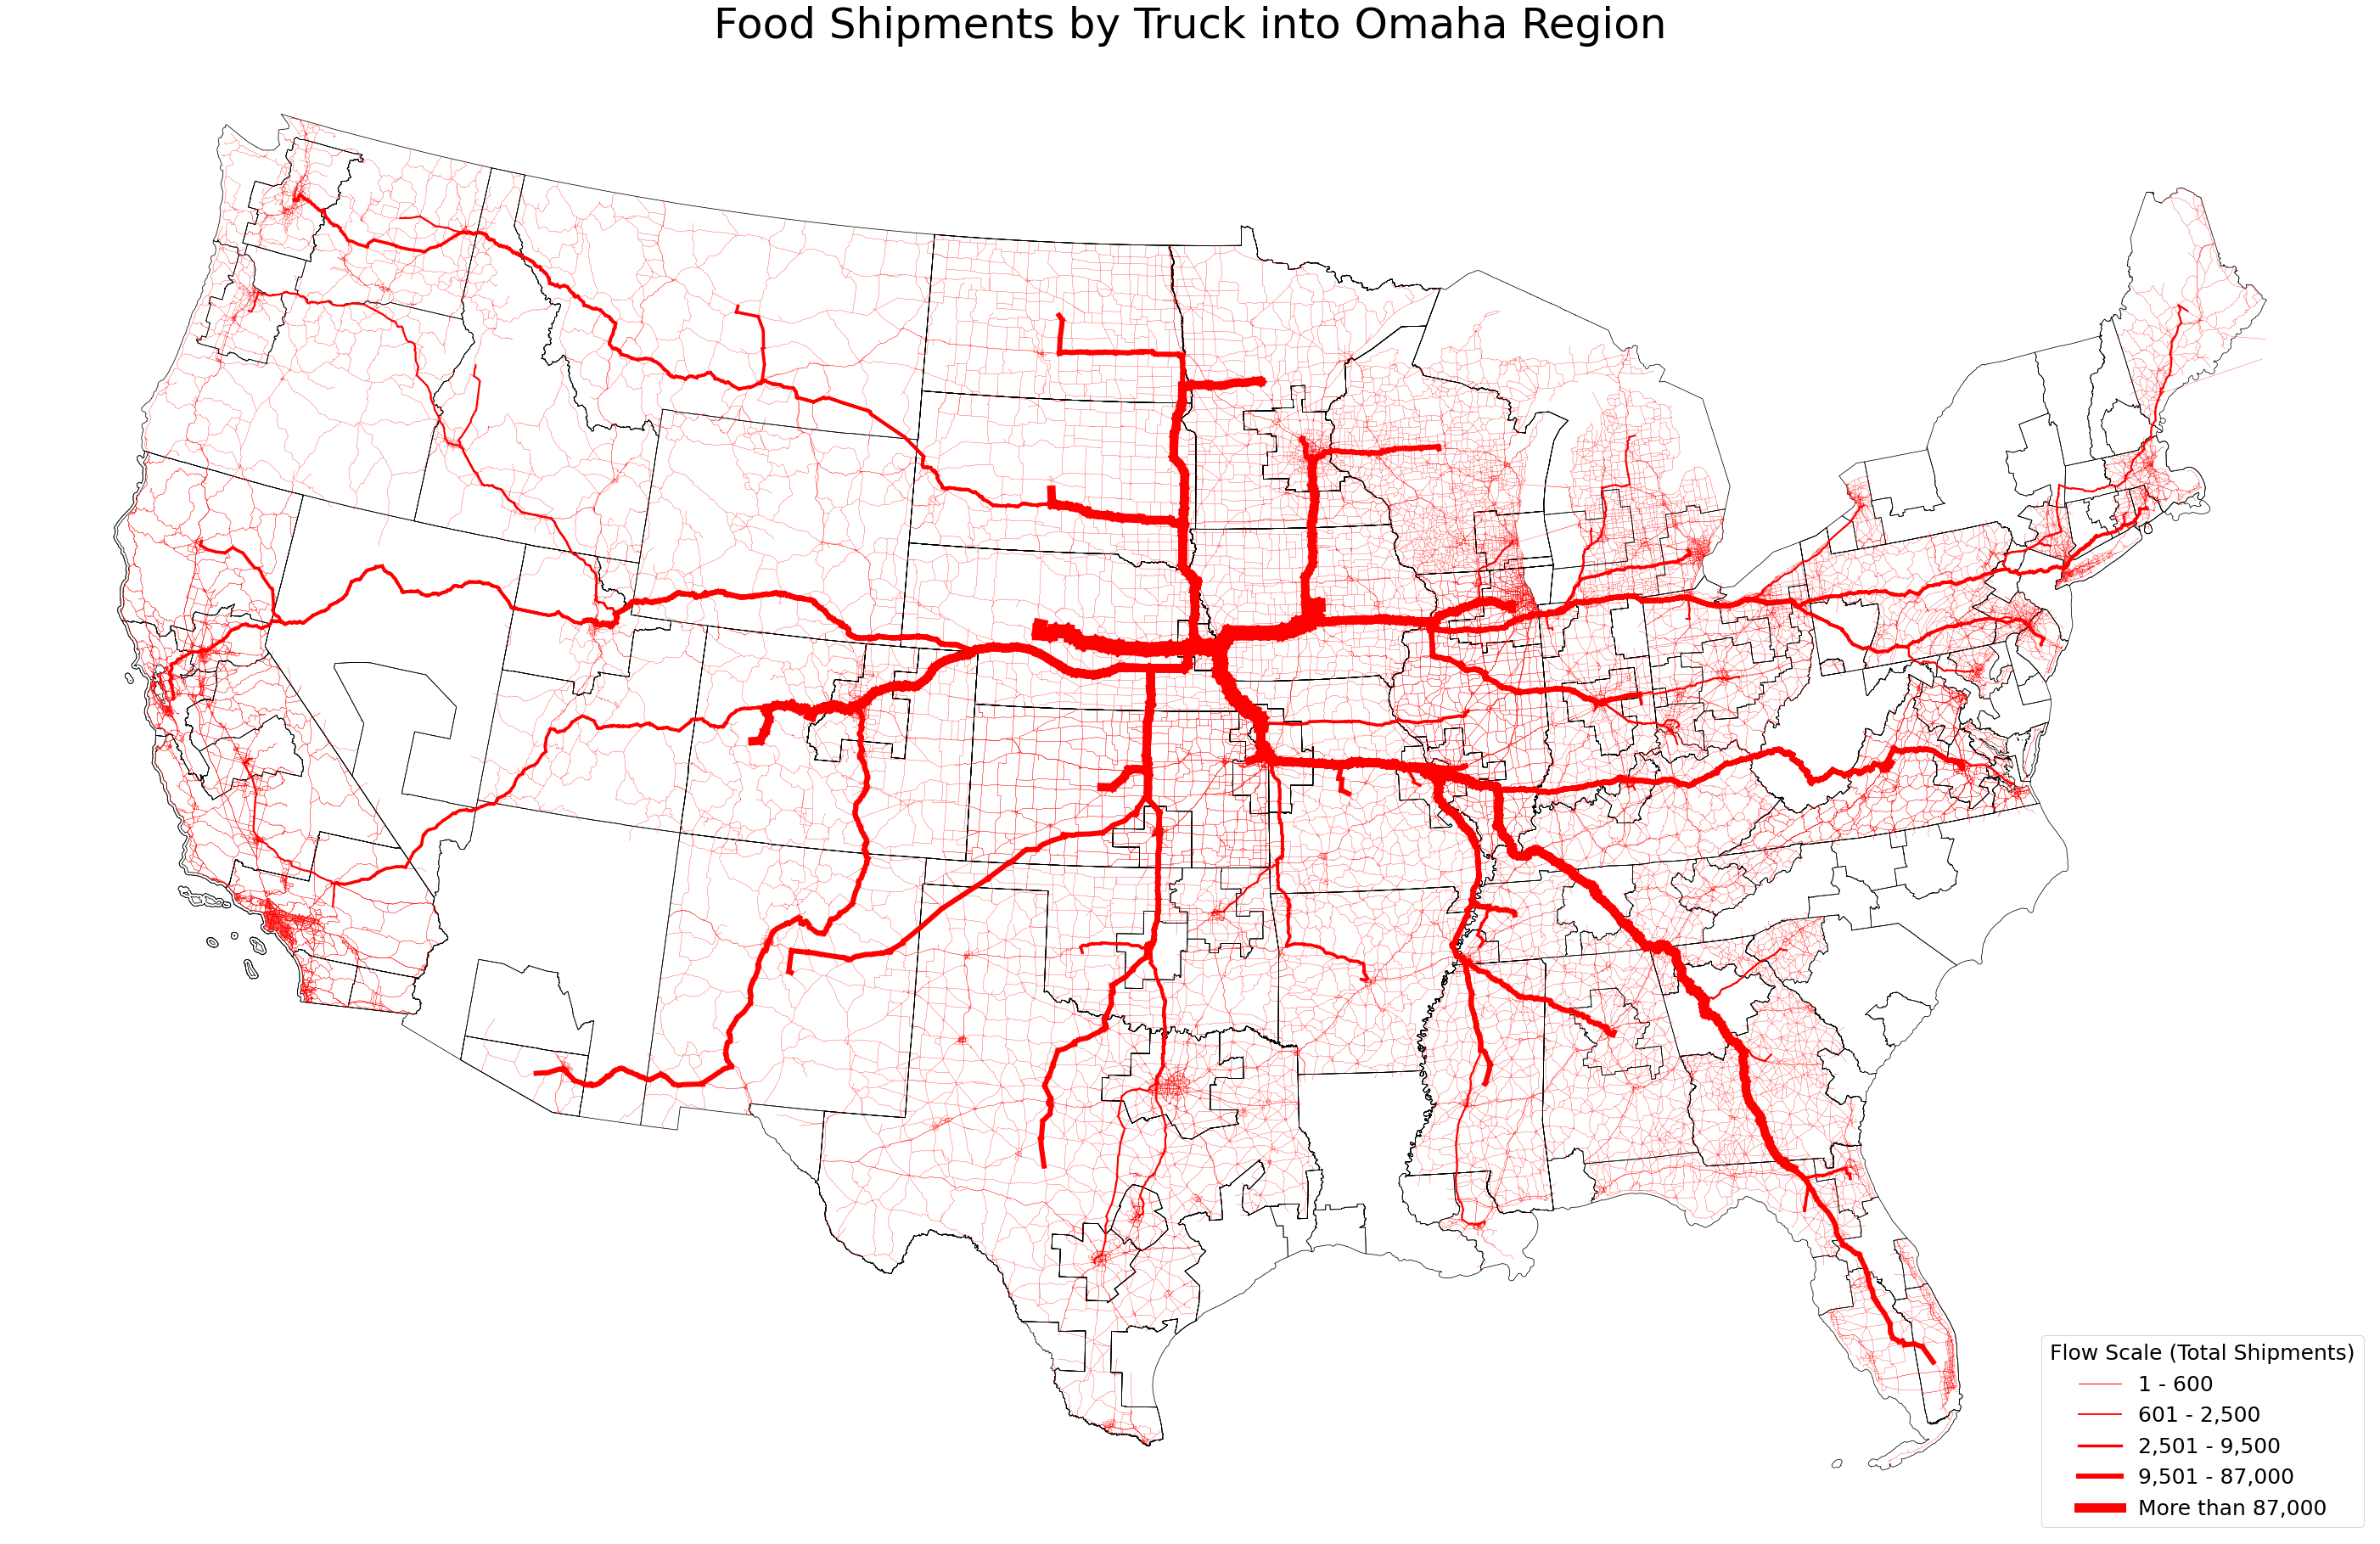

In [ ]:
fig, ax = plt.subplots(figsize=(50,50),subplot_kw={'xticks': [], 'yticks': []})
sctg_gdf.boundary.plot(ax=ax,linewidth=.75,edgecolor='black',zorder=1);
ax.axis('off')
ntwrks_gdf_FAF.plot(linewidth=0.3, ax=ax, color='red',zorder=2);

intrs_route_sum.set_geometry('buffer').plot(ax=ax, linewidth=lin_bins,color='red',zorder=3);

ax.set_title('Food Shipments by Truck into Omaha Region', fontsize='50')
custom_lines = [Line2D([0], [0], color='red', lw=lin_bins.cat.categories[0]),
                Line2D([0], [0], color='red', lw=lin_bins.cat.categories[1]),
                Line2D([0], [0], color='red', lw=lin_bins.cat.categories[2]),
                Line2D([0], [0], color='red', lw=lin_bins.cat.categories[3]),
                Line2D([0], [0], color='red', lw=lin_bins.cat.categories[4])]

ax.legend(custom_lines, ['1 - 600','601 - 2,500','2,501 - 9,500','9,501 - 87,000','More than 87,000'],
          loc='lower right',title='Flow Scale (Total Shipments)', fontsize=25,title_fontsize=25);
plt.savefig('total_shipments_flow_map',orientation='landscape')

#### mapping other values

In [ ]:
lin_bins2 = pd.cut(intrs_route_sum['est_val_1'], bins=[1,5500000,20000000,92500000,575000000,2935901959], labels=np.geomspace(1,11,n))

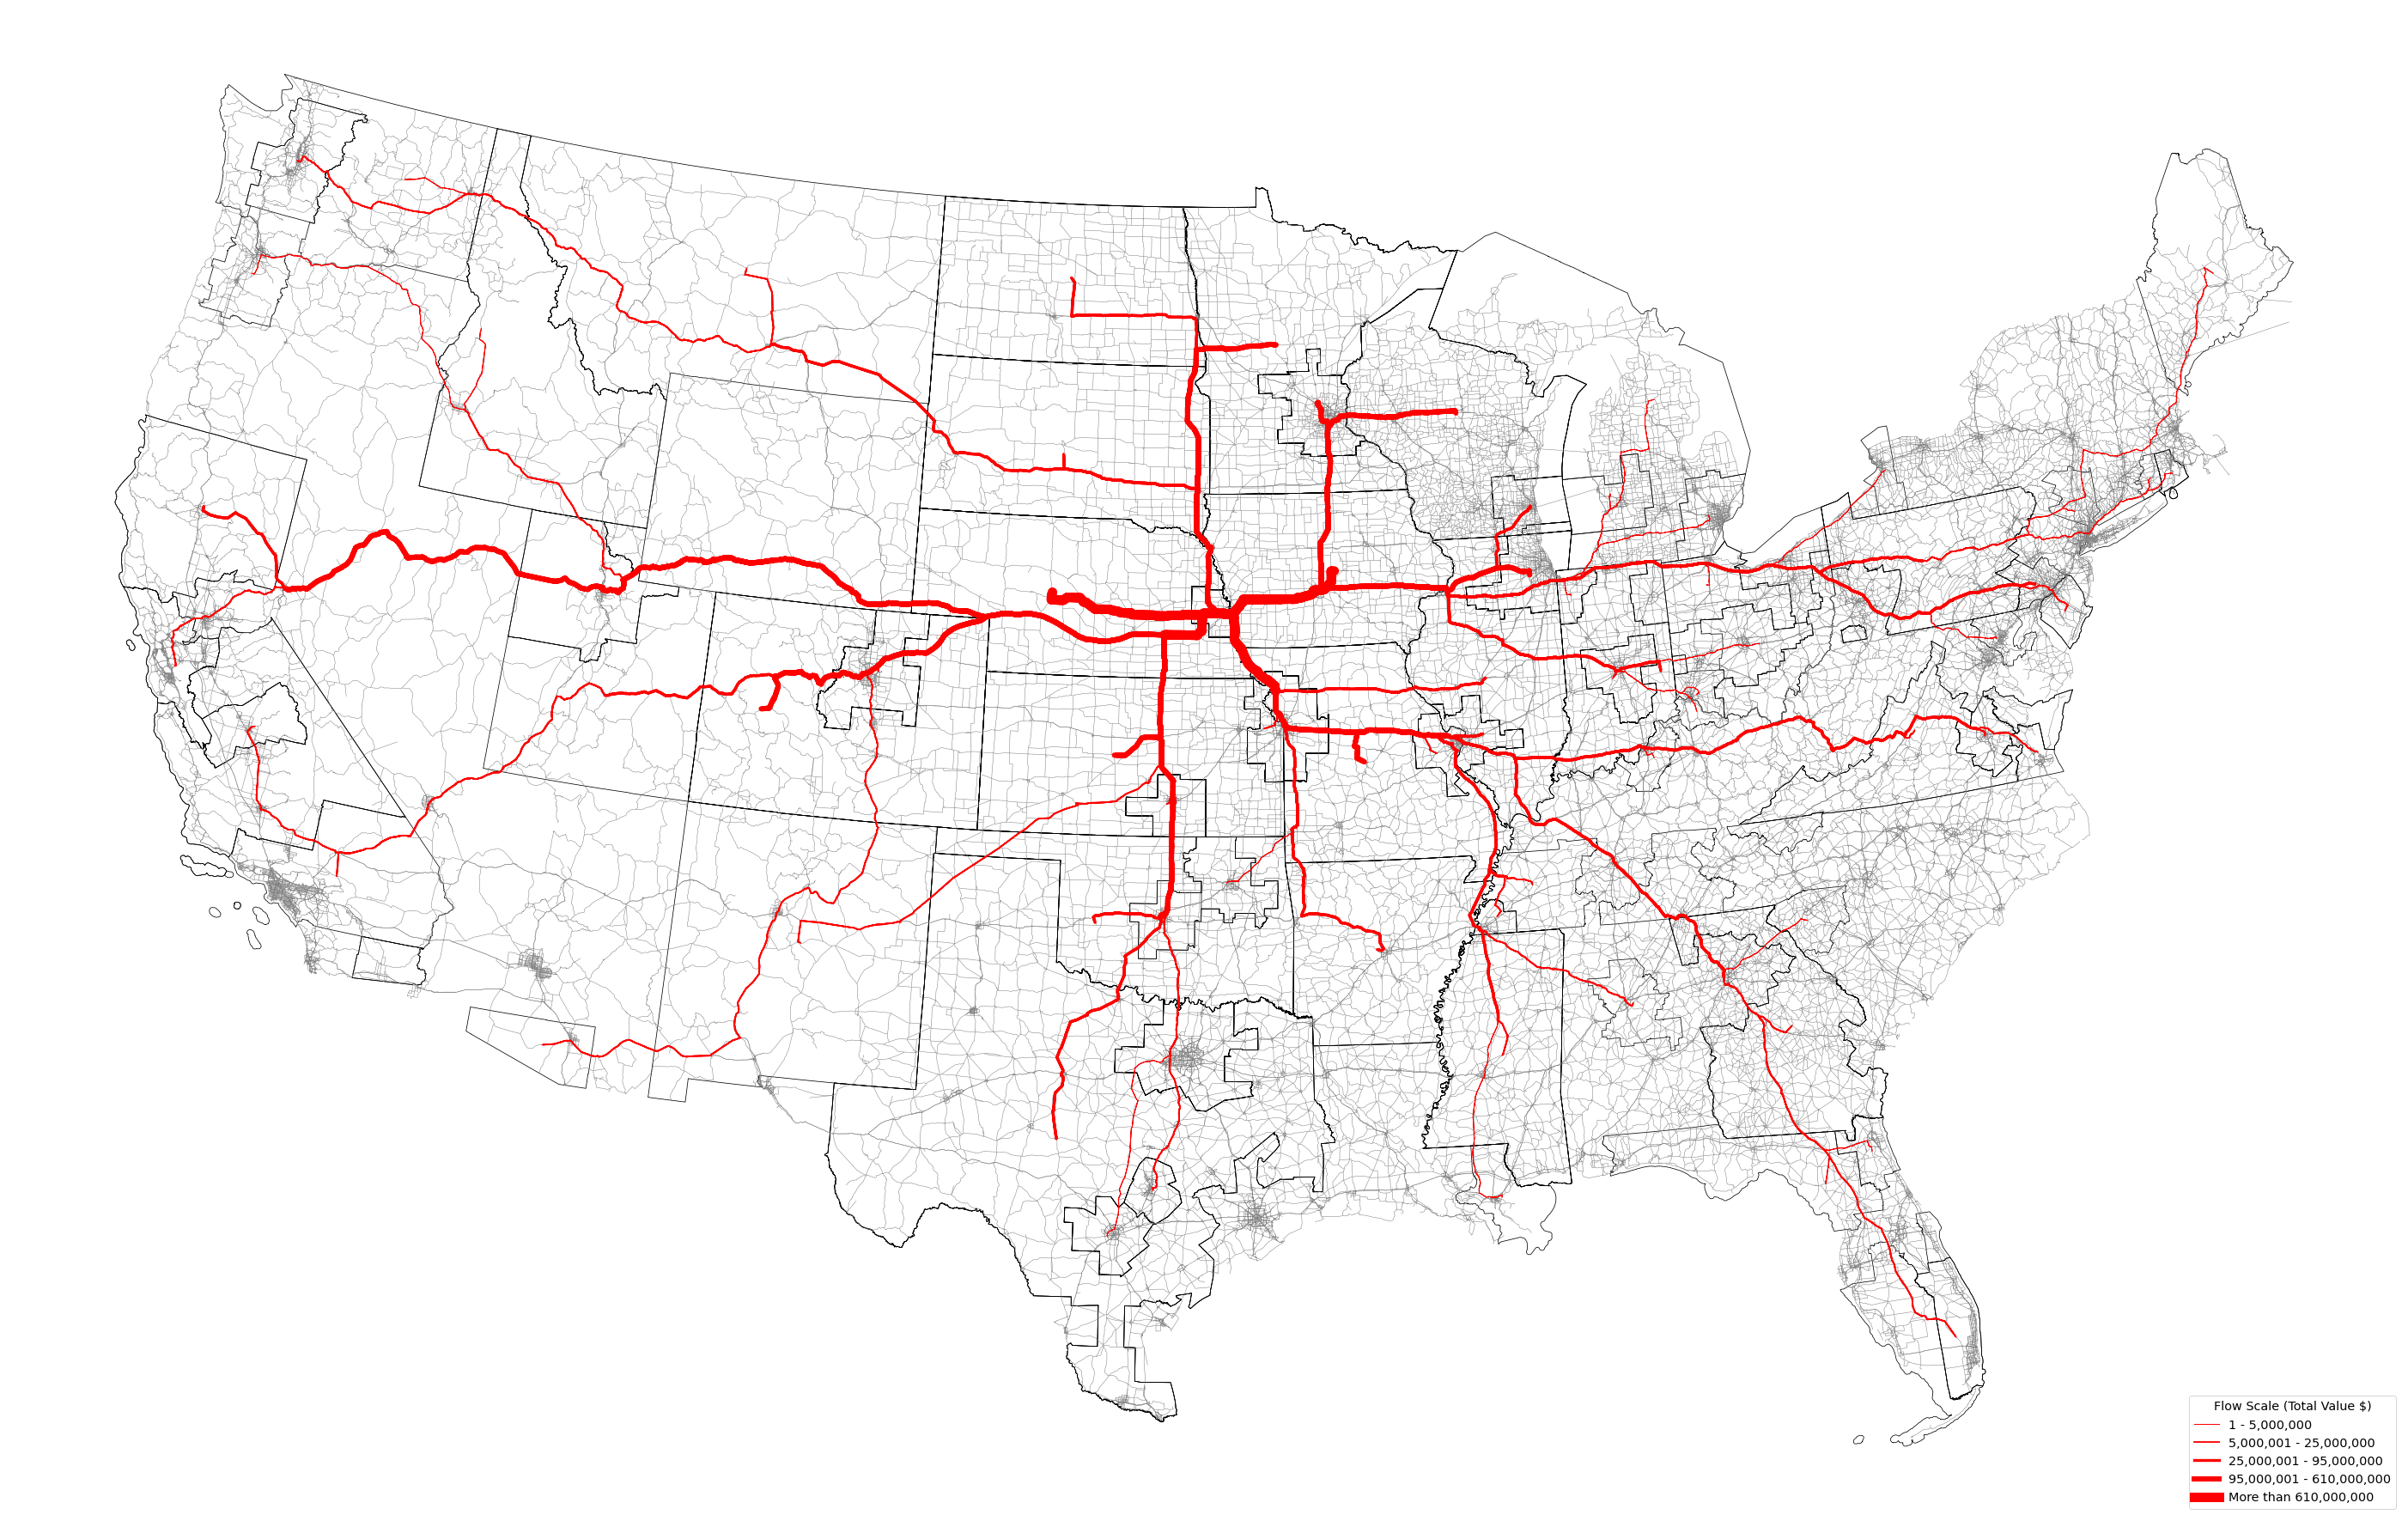

In [ ]:
fig, ax = plt.subplots(figsize=(50,50),subplot_kw={'xticks': [], 'yticks': []})
sctg_gdf_truck.boundary.plot(ax=ax,linewidth=.75,edgecolor='black',);
all_ntwrks_gdf.plot(linewidth=0.5, ax=ax, color='grey');
intrs_route_sum.set_geometry('buffer').exterior.plot(ax=ax, linewidth=lin_bins2,color='red',);
ax.title('Value of Food Shipments into Omaha Region')

custom_lines = [Line2D([0], [0], color='red', lw=lin_bins2.cat.categories[0]),
                Line2D([0], [0], color='red', lw=lin_bins2.cat.categories[1]),
                Line2D([0], [0], color='red', lw=lin_bins2.cat.categories[2]),
                Line2D([0], [0], color='red', lw=lin_bins2.cat.categories[3]),
                Line2D([0], [0], color='red', lw=lin_bins2.cat.categories[4])]

ax.legend(custom_lines, ['1 - 5,500,000','5,500,001 - 20,000,000','20,000,001 - 92,500,000','92,500,001 - 575,000,000','More than 575,000,000'],
          loc='lower right',title='Flow Scale (Total Value $)', fontsize='xx-large',title_fontsize='x-large');

In [ ]:
lin_bins3 = pd.cut(intrs_route_sum['est_lbs_1'], bins=[1,5500000,30000000,250000000,1650000000,6362144807.1], labels=np.geomspace(1,11,n))

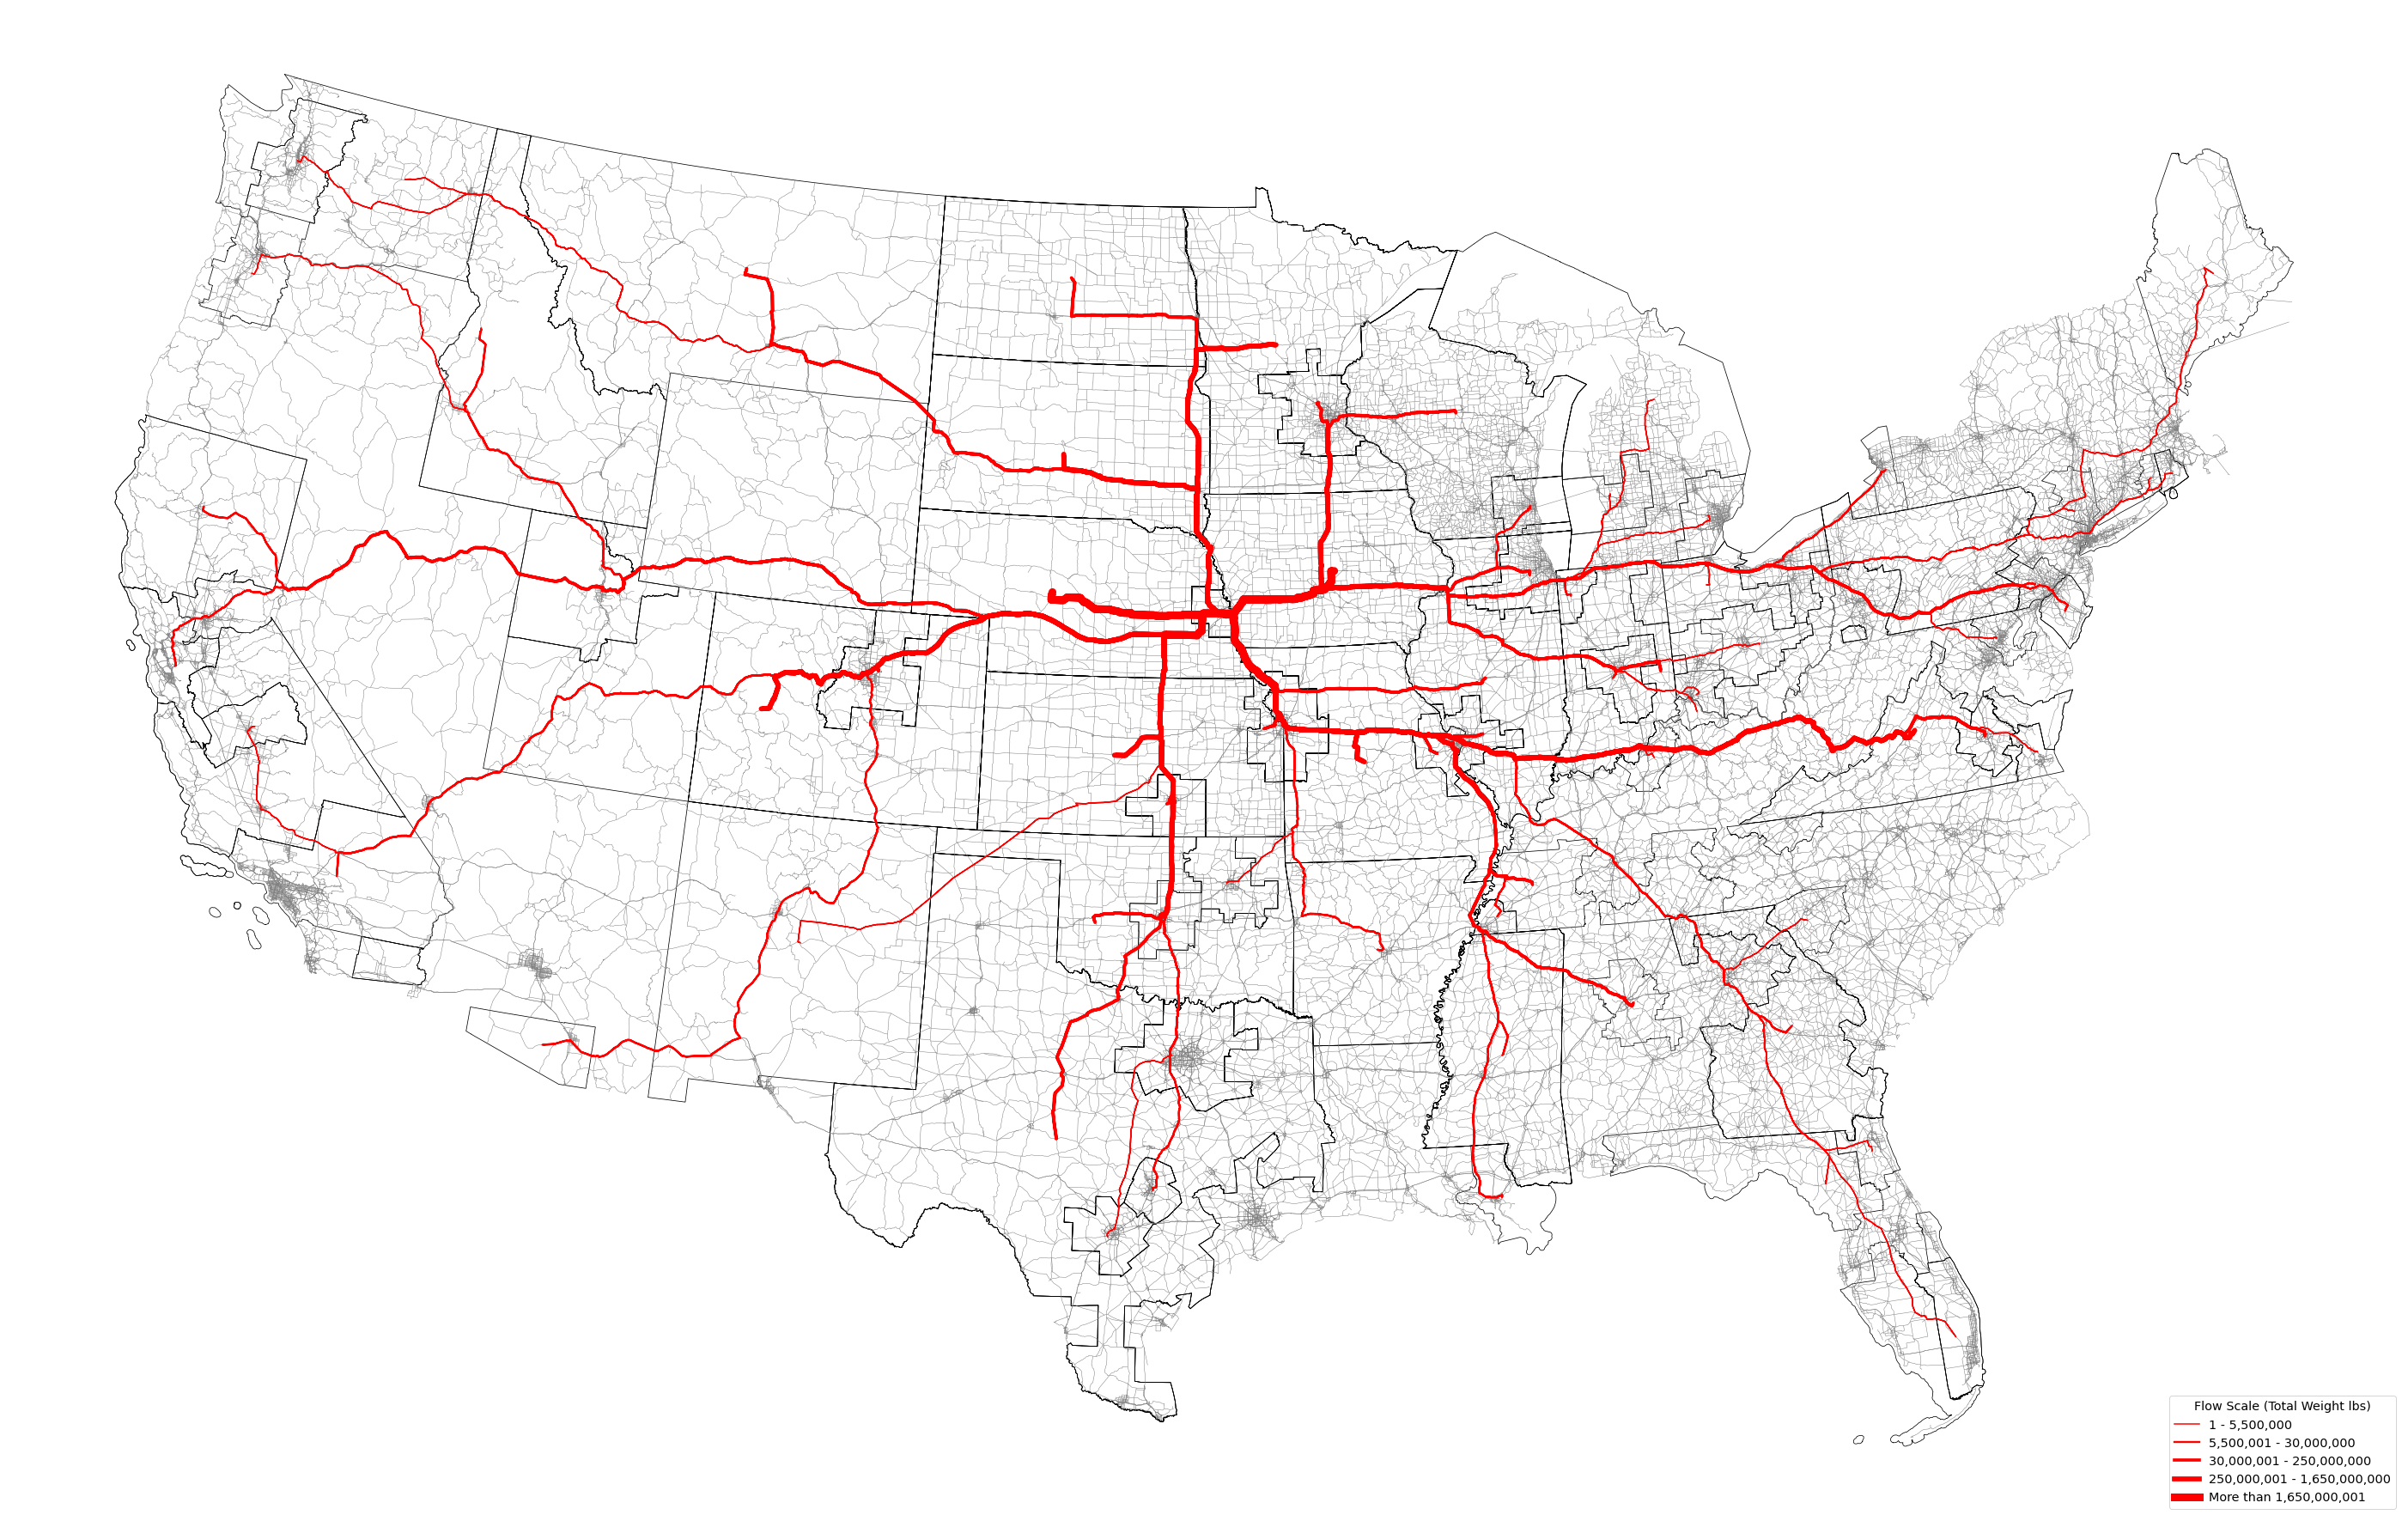

In [ ]:
fig, ax = plt.subplots(figsize=(50,50),subplot_kw={'xticks': [], 'yticks': []})
sctg_gdf_truck.boundary.plot(ax=ax,linewidth=.75,edgecolor='black',);
all_ntwrks_gdf.plot(linewidth=0.5, ax=ax, color='grey');
intrs_route_sum.set_geometry('buffer').exterior.plot(ax=ax, linewidth=lin_bins3,color='red',);

ax.set_title('')
custom_lines = [Line2D([0], [0], color='red', lw=lin_bins3.cat.categories[0]),
                Line2D([0], [0], color='red', lw=lin_bins3.cat.categories[1]),
                Line2D([0], [0], color='red', lw=lin_bins3.cat.categories[2]),
                Line2D([0], [0], color='red', lw=lin_bins3.cat.categories[3]),
                Line2D([0], [0], color='red', lw=lin_bins3.cat.categories[4])]

ax.legend(custom_lines, ['1 - 5,500,000','5,500,001 - 30,000,000','30,000,001 - 250,000,000','250,000,001 - 1,650,000,000','More than 1,650,000,000'],
          loc='lower right',title='Flow Scale (Total Weight lbs)', fontsize='x-large',title_fontsize='x-large');

#### commodity group mapping

In [ ]:
intrs_route_sctg = route_sctg_gdf.overlay(route_sctg_gdf,how='union',keep_geom_type=True,)
intrs_route_sctg = intrs_route_sctg.dissolve(by=['length','SCTG_1'],as_index=False,aggfunc='sum', sort=False)
intrs_route_sctg = intrs_route_sctg.dropna(axis=0,subset=['WGT_FACTOR_1'])[intrs_route_sctg['SCTG_1'] == intrs_route_sctg['SCTG_2'] ].iloc[:,[0,1,2,3,4,5,12,13]].drop_duplicates()
intrs_route_sctg['length'] = intrs_route_sctg['geometry'].length

In [ ]:
['boundary'] = intrs_route_sctg.buffer(1).boundary

In [ ]:
lin_bins4 = pd.cut(intrs_route_sctg['WGT_FACTOR_1'], bins=[1,400,1500,6000,60000,322357.8], labels=np.geomspace(1,11,n))

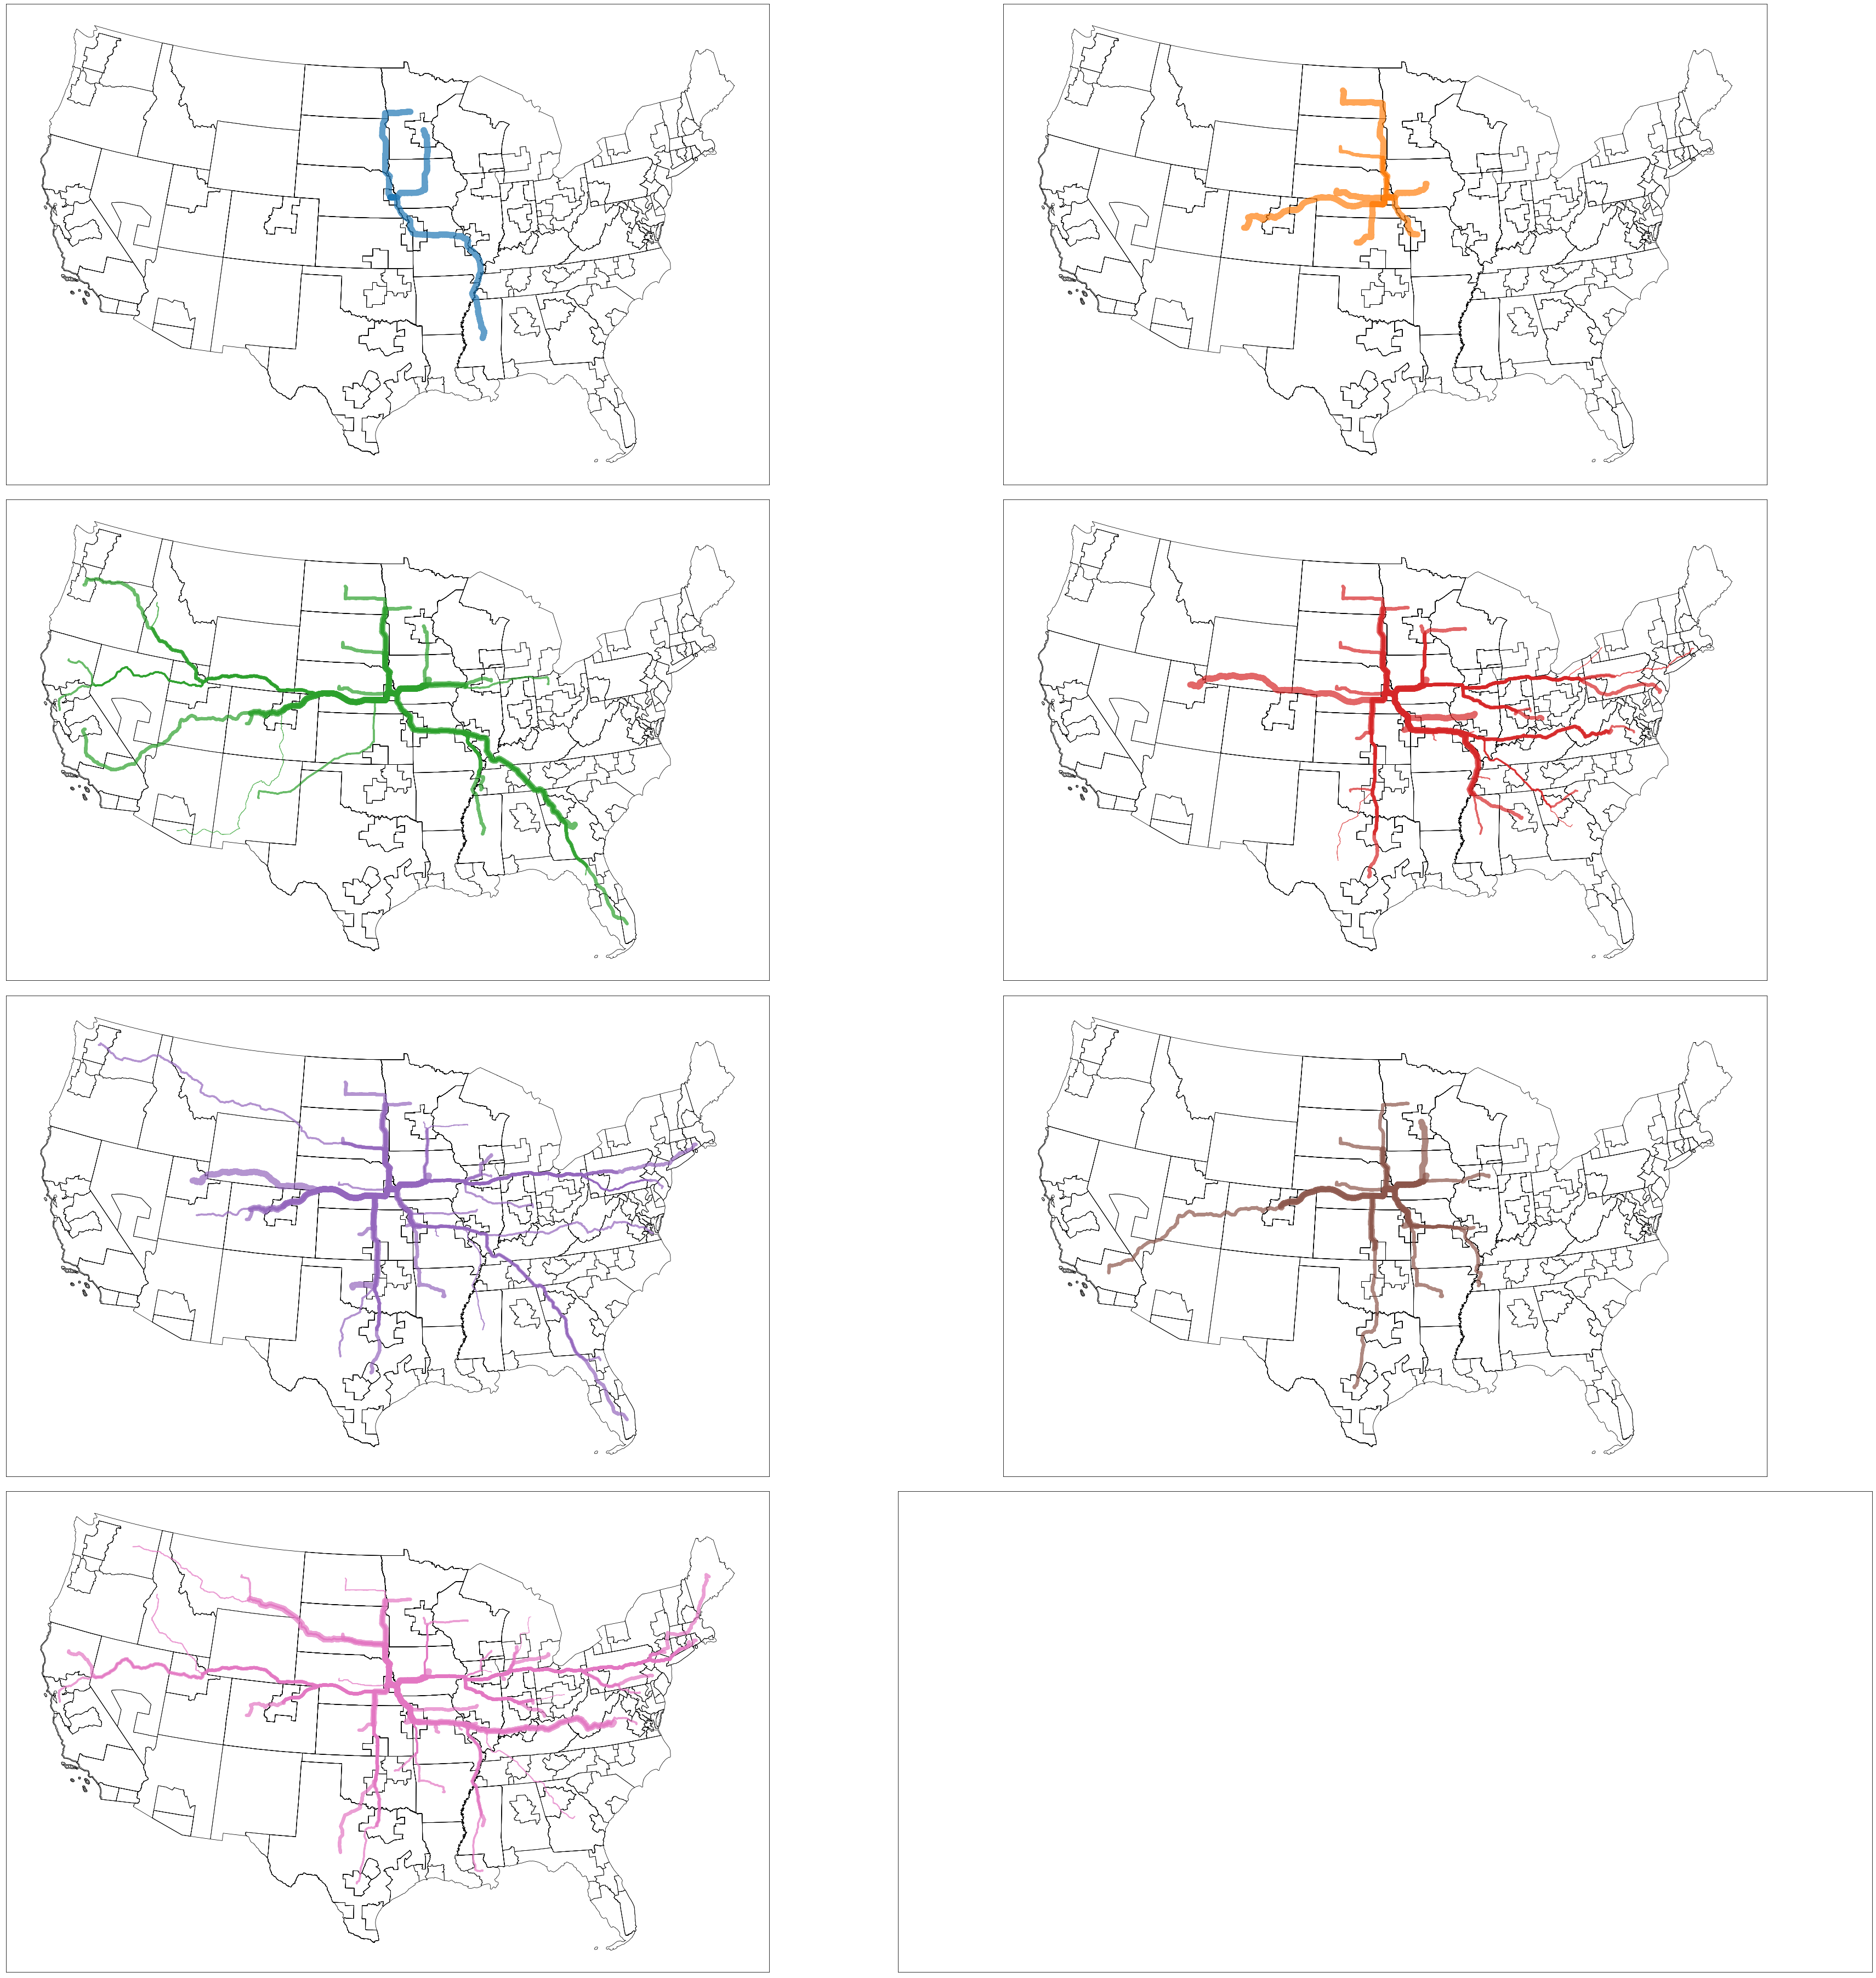

In [ ]:
fig, ax = plt.subplots(4,2, constrained_layout=True, figsize=(50,50),subplot_kw={'xticks': [], 'yticks': []})
sctg_gdf.boundary.plot(ax=ax[0,0],linewidth=.75,edgecolor='black',);
sctg_gdf.boundary.plot(ax=ax[0,1],linewidth=.75,edgecolor='black',);
sctg_gdf.boundary.plot(ax=ax[1,0],linewidth=.75,edgecolor='black',);
sctg_gdf.boundary.plot(ax=ax[1,1],linewidth=.75,edgecolor='black',);
sctg_gdf.boundary.plot(ax=ax[2,0],linewidth=.75,edgecolor='black',);
sctg_gdf.boundary.plot(ax=ax[2,1],linewidth=.75,edgecolor='black',);
sctg_gdf.boundary.plot(ax=ax[3,0],linewidth=.75,edgecolor='black',);


intrs_route_sctg[intrs_route_sctg['SCTG_1'] == 1].set_geometry('buffer').exterior.plot(ax=ax[0,0], linewidth=lin_bins4, alpha=.7, color ='#1f77b4' );
intrs_route_sctg[intrs_route_sctg['SCTG_1'] == 2].set_geometry('buffer').exterior.plot(ax=ax[0,1], linewidth=lin_bins4, alpha=.7, color = '#ff7f0e' );
intrs_route_sctg[intrs_route_sctg['SCTG_1'] == 3].set_geometry('buffer').exterior.plot(ax=ax[1,0], linewidth=lin_bins4, alpha=.7, color = '#2ca02c' );
intrs_route_sctg[intrs_route_sctg['SCTG_1'] == 4].set_geometry('buffer').exterior.plot(ax=ax[1,1], linewidth=lin_bins4, alpha=.7, color = '#d62728' );
intrs_route_sctg[intrs_route_sctg['SCTG_1'] == 5].set_geometry('buffer').exterior.plot(ax=ax[2,0], linewidth=lin_bins4, alpha=.7, color = '#9467bd' );
intrs_route_sctg[intrs_route_sctg['SCTG_1'] == 6].set_geometry('buffer').exterior.plot(ax=ax[2,1], linewidth=lin_bins4, alpha=.7, color = '#8c564b' );
intrs_route_sctg[intrs_route_sctg['SCTG_1'] == 7].set_geometry('buffer').exterior.plot(ax=ax[3,0], linewidth=lin_bins4, alpha=.7, color = '#e377c2' );

#Plotting maps: Visualize trade data and calculate emissions.

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(15,15), subplot_kw={'xticks': [], 'yticks': []})

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.title("Value ($)",fontsize=20,loc='center',pad=20)


sum_gdf[sum_gdf['ORIG_CFS_A_x'] != 0 ].plot(ax=ax,column='est_val', norm=matplotlib.colors.PowerNorm(gamma=.12,vmin=0,vmax=sum_gdf.est_val.max()), cmap='Purples',linewidth=.3,edgecolor='black',legend=False);
sm = plt.cm.ScalarMappable(cmap='Purples', norm=matplotlib.colors.PowerNorm(gamma=.12,vmin=0,vmax=sum_gdf.est_val.max()) )
sm._A = []
cbr = fig.colorbar(sm, cax=cax,)

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(15,15), subplot_kw={'xticks': [], 'yticks': []})

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.title("Weight (lbs)",fontsize=20,loc='center',pad=20)

sum_gdf[sum_gdf['ORIG_CFS_A_x'] != 0 ].plot(ax=ax,column='est_lbs', norm=matplotlib.colors.PowerNorm(gamma=.12,vmin=0,vmax=sum_gdf.est_lbs.max()), cmap='Purples',linewidth=.3,edgecolor='black',legend=False);
sm = plt.cm.ScalarMappable(cmap='Purples', norm=matplotlib.colors.PowerNorm(gamma=.12,vmin=0,vmax=sum_gdf.est_lbs.max()) )
sm._A = []
cbr = fig.colorbar(sm, cax=cax,)

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(15,15), subplot_kw={'xticks': [], 'yticks': []})

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.title("Distance (mi)",fontsize=20,loc='center',pad=20)


sum_gdf[sum_gdf['ORIG_CFS_A_x'] != 0 ].plot(ax=ax,column='est_dst', norm=matplotlib.colors.PowerNorm(gamma=.12,vmin=0,vmax=sum_gdf.est_dst.max()), cmap='Purples',linewidth=.3,edgecolor='black',legend=False);
sm = plt.cm.ScalarMappable(cmap='Purples', norm=matplotlib.colors.PowerNorm(gamma=.12,vmin=0,vmax=sum_gdf.est_dst.max()) )
sm._A = []
cbr = fig.colorbar(sm, cax=cax,)

In [ ]:
fig, ax = plt.subplots(4, 2,figsize=(30,30),constrained_layout=True, subplot_kw={'xticks': [], 'yticks': []})

ax[0,0].set_title('Animals and Fish (live)',fontsize=20)
ax[0,1].set_title('Cereal Grains (includes seed)',fontsize=20)
ax[1,0].set_title('Agricultural Products (excludes Animal Feed, Cereal Grains, and Forage Products)',fontsize=20)
ax[1,1].set_title('Animal Feed, Eggs, Honey, and Other Products of Animal Origin',fontsize=20)
ax[2,0].set_title('Meat, Poultry, Fish, Seafood, and Their Preparations',fontsize=20)
ax[2,1].set_title('Milled Grain Products and Preparations, and Bakery Products',fontsize=20)
ax[3,0].set_title('Other Prepared Foodstuffs, and Fats and Oils',fontsize=20)


divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 1 ].plot(ax=ax[0,0],column='est_lbs', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 1 ].est_lbs.max() ));
sctg_gdf.boundary.plot(ax=ax[0,0],linewidth=1,edgecolor='black',);

divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 2 ].plot(ax=ax[0,1],column='est_lbs', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 2 ].est_lbs.max() ));
sctg_gdf.boundary.plot(ax=ax[0,1],linewidth=1,edgecolor='black',);

divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 3 ].plot(ax=ax[1,0],column='est_lbs', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 3 ].est_lbs.max() ));
sctg_gdf.boundary.plot(ax=ax[1,0],linewidth=1,edgecolor='black',);

divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 4 ].plot(ax=ax[1,1],column='est_lbs', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 4 ].est_lbs.max() ));
sctg_gdf.boundary.plot(ax=ax[1,1],linewidth=1,edgecolor='black',);

divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 5 ].plot(ax=ax[2,0],column='est_lbs', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 5 ].est_lbs.max() ));
sctg_gdf.boundary.plot(ax=ax[2,0],linewidth=1,edgecolor='black',);

divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 6 ].plot(ax=ax[2,1],column='est_lbs', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 6 ].est_lbs.max() ));
sctg_gdf.boundary.plot(ax=ax[2,1],linewidth=1,edgecolor='black',);

divider = make_axes_locatable(ax[3,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 7 ].plot(ax=ax[3,0],column='est_lbs', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 7 ].est_lbs.max() ) );
sctg_gdf.boundary.plot(ax=ax[3,0],linewidth=1,edgecolor='black',);

In [ ]:
fig, ax = plt.subplots(4, 2,figsize=(30,30),constrained_layout=True, subplot_kw={'xticks': [], 'yticks': []})


ax[0,0].set_title('Animals and Fish (live)',fontsize=20)
ax[0,1].set_title('Cereal Grains (includes seed)',fontsize=20)
ax[1,0].set_title('Agricultural Products (excludes Animal Feed, Cereal Grains, and Forage Products)',fontsize=20)
ax[1,1].set_title('Animal Feed, Eggs, Honey, and Other Products of Animal Origin',fontsize=20)
ax[2,0].set_title('Meat, Poultry, Fish, Seafood, and Their Preparations',fontsize=20)
ax[2,1].set_title('Milled Grain Products and Preparations, and Bakery Products',fontsize=20)
ax[3,0].set_title('Other Prepared Foodstuffs, and Fats and Oils',fontsize=20)


divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 1 ].plot(ax=ax[0,0],column='est_val', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 1 ].est_val.max() ));
sctg_gdf.boundary.plot(ax=ax[0,0],linewidth=1,edgecolor='black',);

divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 2 ].plot(ax=ax[0,1],column='est_val', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 2 ].est_val.max() ));
sctg_gdf.boundary.plot(ax=ax[0,1],linewidth=1,edgecolor='black',);

divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 3 ].plot(ax=ax[1,0],column='est_val', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 3 ].est_val.max() ));
sctg_gdf.boundary.plot(ax=ax[1,0],linewidth=1,edgecolor='black',);

divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 4 ].plot(ax=ax[1,1],column='est_val', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 4 ].est_val.max() ));
sctg_gdf.boundary.plot(ax=ax[1,1],linewidth=1,edgecolor='black',);

divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 5 ].plot(ax=ax[2,0],column='est_val', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 5 ].est_val.max() ));
sctg_gdf.boundary.plot(ax=ax[2,0],linewidth=1,edgecolor='black',);

divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 6 ].plot(ax=ax[2,1],column='est_val', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 6 ].est_val.max() ));
sctg_gdf.boundary.plot(ax=ax[2,1],linewidth=1,edgecolor='black',);

divider = make_axes_locatable(ax[3,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] == 7 ].plot(ax=ax[3,0],column='est_val', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.LogNorm(vmin=1,vmax=sctg_gdf[sctg_gdf['SCTG'] == 7 ].est_val.max() ) );
sctg_gdf.boundary.plot(ax=ax[3,0],linewidth=1,edgecolor='black',);

In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(30,30),constrained_layout=True, subplot_kw={'xticks': [], 'yticks': []})



ax[0].set_title('Unprocessed Foodstuffs',fontsize=20)
ax[1].set_title('Processed Foodstuffs',fontsize=20)



divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[(sctg_gdf['SCTG'] < 5) & (sctg_gdf['SCTG'] != 1.05) ].plot(ax=ax[0],column='est_val', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.PowerNorm(gamma=.12,vmin=0,vmax=sctg_gdf[(sctg_gdf['SCTG'] < 5) & (sctg_gdf['SCTG'] != 1.05)  ].est_val.max() ));
sctg_gdf.boundary.plot(ax=ax[0],linewidth=1,edgecolor='black',);

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] >= 5 ].plot(ax=ax[1],column='est_val', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.PowerNorm(gamma=.12,vmin=0,vmax=sctg_gdf[sctg_gdf['SCTG'] >= 5  ].est_val.max() ));
sctg_gdf.boundary.plot(ax=ax[1],linewidth=1,edgecolor='black',);


In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(30,30),constrained_layout=True, subplot_kw={'xticks': [], 'yticks': []})



ax[0].set_title('Unprocessed Foodstuffs',fontsize=20)
ax[1].set_title('Processed Foodstuffs',fontsize=20)



divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[(sctg_gdf['SCTG'] < 5) & (sctg_gdf['SCTG'] != 1.05)].plot(ax=ax[0],column='est_lbs', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.PowerNorm(gamma=.12,vmin=0,vmax=sctg_gdf[(sctg_gdf['SCTG'] < 5) & (sctg_gdf['SCTG'] != 1.05)].est_lbs.max() ));
sctg_gdf.boundary.plot(ax=ax[0],linewidth=1,edgecolor='black',);
sctg_gdf[sctg_gdf['ORIG_CFS_A_x'] == '31-420'].boundary.plot(ax=ax[0],linewidth=2,edgecolor='red',);

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
sctg_gdf[sctg_gdf['SCTG'] >= 5 ].plot(ax=ax[1],column='est_lbs', cmap='Greens',linewidth=.3,edgecolor='black',legend=True,cax=cax,
                                      norm=matplotlib.colors.PowerNorm(gamma=.12,vmin=0,vmax=sctg_gdf[sctg_gdf['SCTG'] >= 5  ].est_lbs.max() ));
sctg_gdf.boundary.plot(ax=ax[1],linewidth=1,edgecolor='black',);
sctg_gdf[sctg_gdf['ORIG_CFS_A_x'] == '31-420'].boundary.plot(ax=ax[1],linewidth=2,edgecolor='red',);

Emissions


In [ ]:
ghg = ao_gdf.groupby('MODE').sum()['ton_miles']

In [ ]:
( ((ghg[ghg.index == 4].iloc[0] + ghg[ghg.index == 5].iloc[0]) * 161.8 )  + (ghg[ghg.index == 6].iloc[0] * 22.9) + (ghg[ghg.index == 11].iloc[0]  * 868.3)  ) /1000000

339558.38917415065

In [ ]:
ao_gdf['ton_miles'] = (ao_gdf['WGT_FACTOR'] * ao_gdf['SHIPMT_WGH']/2000 * ao_gdf['SHIPMT_D_1'])